# 계산을 위한 Code

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import brute
import pyupbit
from datetime import datetime
import time
from dateutil.relativedelta import relativedelta
import warnings
from typing import *
import pandas_ta as ta
import talib
import empyrical as ep
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
class Action:
    """
    Abstract class for Order, OrderCancellation
    """
    def __init__(self):
        pass
class Strategy:
    """
    Abstract method for generating user-defined trading strategies with certis
    """
#     def __init__(self, config, name="CertisStrategy"):
#         self.config = config
#         self.name = name

    def _calculate(self, data):
        return data

    def calculate(self, data: pd.DataFrame):
        return self._calculate(data)

    def execute(self, state_dict: Dict[str, Any]) -> List[Action]:
        raise NotImplementedError
def _power10(x):
    return np.power(10,x)
def _sma(series, n):
    return series.rolling(n).mean()
def cal_ma(data, method = 'sma', length=5):
    if method == 'sma':
        ma_result = ta.sma(data, length=length, talib=False)
    elif method == 'ema':
        ma_result = ta.ema(data, length=length, talib=False)
    elif method == 'wma':
        ma_result = ta.wma(data, length=length, talib=False)
    else:
        raise ValueError('Check ma method')
    return ma_result

In [3]:
class Backtest():
    def __init__(self, price_data: pd.DataFrame, strategy_cls:type, strategy_list:None):
        self.price_data = price_data
        self.strategy_list = strategy_list
        self.strategy : Strategy = strategy_cls(self.price_data,self.strategy_list)
        
        self.trading_fee = 0.05
        self.case_name = None
        
    def cal_strategy(self):
        self.test_result = self.strategy.calculate()  # finish_daily : 일별로 거래 종료되어 position이 거래횟수
    def cal_result(self):
        data = self.test_result.copy()
        # 에러발생코드
#         data['strategy_return'].fillna(0,inplace=True)
        if (data.buy_entry.sum() == 0) & (data.buy_exit.sum() == 0):
            raise ValueError('Buy_Entry, Buy_Exit 가 없음')
        # 수수료 반영
        if not self.trading_fee == 0:
            data['strategy_return'] = data['strategy_return'] + data['buy_entry'] * np.log10(1-(self.trading_fee*0.01))
            data['strategy_return'] = data['strategy_return'] + data['buy_exit'] * np.log10(1-(self.trading_fee*0.01))
        
        data['strategy'] = data['strategy_return'].fillna(0)      
        data['creturns'] = data['return'].cumsum()
        data['cstrategy'] = data['strategy'].cumsum()
#         aperf = data['cstrategy'].iloc[-1]
#         operf = aperf - data['creturns'].iloc[-1]
        self.results = data
#         return round(aperf, 2), round(operf, 2)
        return round(data['creturns'].iloc[-1],2), round(data['cstrategy'].iloc[-1],2)
    def analyze_result_ind(self):
        data = self.results.copy()
        self.analysis_ind = _analyze_result_ind(data)
        return f'거래횟수 (수익, 승률 ) : {self.analysis_ind[0]} ( {self.analysis_ind[1]}, {self.analysis_ind[2]:.2f}), 평균 수익률 % (수익, 손실, 손익비) : {self.analysis_ind[4]:.2f} ({self.analysis_ind[5]:.2f}, {self.analysis_ind[6]:.2f}, {self.analysis_ind[3]:.2f})'
#     self.analysis_ind
# [number_of_trading , number_of_trading_positive, hit_ratio, -average_gain/average_loss, expactacy_per_trade, average_gain, average_loss]
    def plot_results(self, markup=False):
        data = self.results.copy()
        _plot_results(data, markup)
    def analyze_result_per(self):
        data = self.results.copy()
        self.analysis_per = _analyze_result_per(data)
        return self.analysis_per
    def plot_analysis_per(self):
        data = self.analysis_per.copy()
        _plot_analysis_per(data)
    
    def analyze_result_cont(self):
        data = self.results.copy()
        self.analysis_cont = _analyze_result_cont(data)
        return f'전체수익 : {self.analysis_cont[0]:.2f} %, CAGR : {self.analysis_cont[1]:.2f} %, MDD : {self.analysis_cont[2]:.2f} %, STD : {self.analysis_cont[3]:.2f} %, Sharpe : {self.analysis_cont[4]:.2f}'
    def add_log_result(self):
        _add_log_result([self.case_name], self.analysis_ind, self.analysis_cont)
    def delete_log_result(self):
        _delete_log_resulte()

In [4]:
def _plot_results(data, markup):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    ax1.plot(data[['creturns', 'cstrategy']], label=['creturns', 'cstrategy'])
#     ax2 = ax1.twinx()
#     ax2.plot(data[['sma_short','sma_mid','sma_long']], label=['sma_short','sma_mid','sma_long'])
#     plt.plot(data[['creturns', 'cstrategy']], label=['creturns', 'cstrategy'])
#     plt.plot(data[['creturns', 'cstrategy','sma_short','sma_mid','sma_long']], label=['creturns', 'cstrategy','sma_short','sma_mid','sma_long'])
    plt.legend()
    if markup:
        signal_buy = np.where(data.buy_entry > data.buy_entry.shift(1) , 1, 0)
        signal_sell = np.where(data.buy_exit > data.buy_exit.shift(1), 1, 0)
        date_buy = list(data[signal_buy==1].index)
        date_sell = list(data[signal_sell==1].index)
        if len(date_buy)==0:
            raise ValueError('거래가 발생하지 않음.')
        if len(date_sell)+1 == len(date_buy):
            date_sell.append(data.index[-1])
        if date_sell[0] < date_buy[0]:
            date_sell = date_sell[1:]
        for date_start, date_end in zip(date_buy, date_sell):
            plt.axvspan(date_start, date_end, facecolor='gray', alpha=0.5)
    plt.show() 
def _analyze_result_ind(data):
    # list_trading_period, list_trading_profit 계산
    list_trading_period = []
    list_trading_profit = []
    return_adj_temp = np.nan
    for return_adj,buy_entry,buy_exit in zip(data.strategy_return,data.buy_entry,data.buy_exit):
        if (buy_entry==1)&(buy_exit==1):
            list_trading_period.append(1)
            list_trading_profit.append(_power10(return_adj))
        elif (buy_entry==1)&(buy_exit==0):
            return_adj_temp = return_adj
            trading_period_temp = 1
        elif (buy_entry==0)&(buy_exit==0):
            if np.isnan(return_adj_temp):
                continue
            else:
                return_adj_temp += return_adj
                trading_period_temp += 1
        elif (buy_entry==0)&(buy_exit==1):
            return_adj_temp += return_adj
            trading_period_temp += 1
            list_trading_period.append(trading_period_temp)
            list_trading_profit.append(_power10(return_adj_temp))
        else:
            print("Check Data")
            raise ValueError
#     return list_trading_period, list_trading_profit 
    # 잔여 항목 계산
    array_trading_period = np.array(list_trading_period)
    array_trading_profit = np.array(list_trading_profit)
    number_of_trading = len(array_trading_period)
    array_trading_profit_positive = array_trading_profit[array_trading_profit>1]
    array_trading_profit_negative = array_trading_profit[array_trading_profit<=1]
    number_of_trading_positive = len(array_trading_profit_positive)
    number_of_trading_negative = len(array_trading_profit_negative)
    hit_ratio = number_of_trading_positive / number_of_trading
    expactacy_per_trade = (array_trading_profit_positive.sum()+array_trading_profit_negative.sum())/number_of_trading-1
    average_gain = array_trading_profit_positive.mean()-1
    average_loss = array_trading_profit_negative.mean()-1
    largest_gain = array_trading_profit_positive.max()-1
    largest_loss = array_trading_profit_negative.min()-1
    analysis_ind = [number_of_trading , number_of_trading_positive, round(hit_ratio,2), round(-average_gain/average_loss,2), round(expactacy_per_trade*100,2), round(average_gain*100,2), round(average_loss*100,2)]
    return analysis_ind
def _analyze_result_cont(data : pd.DataFrame = pd.DataFrame()):
    trade_year = (list(data.index)[-1] - list(data.index)[0]).days / 365
    
    total_profit = _power10(data.cstrategy.iloc[-1]) #본전이면 1
#     print(total_profit, trade_year)
    cagr = (total_profit ** (1 / trade_year) - 1) # 본전이면 0
    mdd = ep.max_drawdown(data.strategy.apply(_power10)-1)
    
    std = data.strategy.dropna().std() * (365 ** 0.5)
    
    risk_free_rate = 0
    sharpe_ratio = (cagr - risk_free_rate) / std
    
    analysis_cont = [round(total_profit*100-100,2), round(cagr*100,2), round(mdd*100,2), round(std*100,2), round(sharpe_ratio,2)]
#     print(f"--------------------\n전체 수익 : {total_profit*100:.2f} ( {cagr:.2f} )\nMDD : {mdd:.2f}\nSTD : {std:.2f}\nSharpe Ratio : {sharpe_ratio:.2f}")
    return analysis_cont 
def _analyze_result_per(data):
    # list_trading_period, list_trading_profit 계산
    list_trading_period = [] # 몇 거래일동안 거래하는지
    list_trading_date_start = []  # 거래시작일
    list_trading_date_end = []  # 거래종료일
    list_trading_profit = []  #거래 당 수익률
    return_adj_temp = np.nan
    for return_adj,buy_entry,buy_exit,date in zip(data.strategy_return,data.buy_entry,data.buy_exit,data.index):
        if (buy_entry==1)&(buy_exit==1):
            list_trading_period.append(1)
            list_trading_date_start.append(date)
            list_trading_date_end.append(date)
            list_trading_profit.append(_power10(return_adj))
        elif (buy_entry==1)&(buy_exit==0):
            list_trading_date_start.append(date)
            return_adj_temp = return_adj
            trading_period_temp = 1
        elif (buy_entry==0)&(buy_exit==0):
            if np.isnan(return_adj_temp):
                continue
            else:
                return_adj_temp += return_adj
                trading_period_temp += 1
        elif (buy_entry==0)&(buy_exit==1):
            list_trading_date_end.append(date)
            return_adj_temp += return_adj
            trading_period_temp += 1
            list_trading_period.append(trading_period_temp)
            list_trading_profit.append(_power10(return_adj_temp))
        else:
            print("Check Data")
            raise ValueError
   
    df_trading_ind = pd.DataFrame(columns = ['trading_no','profit'], index =  list_trading_date_start)
    df_trading_ind['trading_no'] = list_trading_period
    df_trading_ind['profit'] = np.array(list_trading_profit)-1
    
    df_trading_ind_month = df_trading_ind.resample('M').apply({'trading_no':'sum','profit':'sum'})
  
    return df_trading_ind_month
def _plot_analysis_per(data):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    ax1.plot(data['trading_no'], color = 'red')
    ax1.set_ylabel('trading_no', color = 'red', rotation = 90)
    ax1.set_ylim(0, 30)
    ax2 = ax1.twinx()
    ax2.plot(data['profit'], color = 'blue')
    ax2.set_ylabel('profit', color = 'blue', rotation = 90)
    # ax2.set_ylim(-1, 1)
#     plt.legend()
    plt.show()
def _delete_log_result():
    if 'dict_log_result' in globals():
        global dict_log_result 
        del dict_log_result
        print("log 삭제 완료")
    else:
        print("log가 존재하지 않음")
def _add_log_result(*informations):
    if not 'dict_log_result' in globals():
        global dict_log_result 
        dict_log_result = {}
#         pass
    result_temp = []
    for information in informations:
        result_temp += information
    dict_log_result[f'case {len(dict_log_result)+1}'] = result_temp
    return dict_log_result
def _return_log_result(log_result=None):
    if not 'dict_log_result' in globals():
        print('log가 존재하지 않음')
    else:
        global dict_log_result
        name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
        df = pd.DataFrame(dict_log_result,index=name_list).T
        number_of_trading_allCoin = int(df.number_of_trading.sum())
        number_of_trading_positive_allCoin = df.number_of_trading_positive.sum()
        number_of_trading_negative_allCoin = number_of_trading_allCoin - number_of_trading_positive_allCoin
        hit_ratio_allCoin = number_of_trading_positive_allCoin / number_of_trading_allCoin
        average_gain_allCoin = (df.number_of_trading_positive * df.average_gain).sum() / number_of_trading_positive_allCoin
        average_loss_allCoin = ((df.number_of_trading - df.number_of_trading_positive) * df.average_loss).sum() / (number_of_trading_negative_allCoin)
        expactacy_per_trade_allCoin = (average_gain_allCoin*number_of_trading_positive_allCoin + average_loss_allCoin*number_of_trading_negative_allCoin) / number_of_trading_allCoin
        gain_loss_ratio_allCoin = -average_gain_allCoin / average_loss_allCoin
#         print("----------결과분석----------")
        print(f'--------------------\n거래횟수 (상승) : {number_of_trading_allCoin} ( {number_of_trading_positive_allCoin} )\n승률 : {hit_ratio_allCoin:.2f}\n손익비 : {-average_gain_allCoin/average_loss_allCoin:.2f}\n거래 당 기대수익률 (상승/하락) : {expactacy_per_trade_allCoin:.2f} ( {average_gain_allCoin:.2f} / {average_loss_allCoin:.2f} )')

In [5]:
date_start = datetime(2015,10,1)
date_end = datetime(2022,10,10)
# date_end = datetime(2022,3,31)
code_coin = 'KRW-BTC'

def define_data ( start , end , code, timeframe = 'daily', time_start = 9 ) :
    if timeframe == 'daily':
        if time_start == 9:
            data_all = pd.read_pickle("data_coin_daily.pkl")
            data_all = data_all[data_all.coin == code]
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
        else:
            data_hourly = pd.read_pickle('data_coin_hourly.pkl')
            data_hourly = data_hourly[data_hourly.coin == code]
            start_datetime = start.replace(hour=time_start)
            data_hourly = data_hourly[data_hourly.date >= start_datetime]
            data_hourly.index = data_hourly.date
            dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','volume':'sum','date':'first'}
            data_all = data_hourly.resample('24H',origin=start_datetime).apply(dict_ohlcv)
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    elif timeframe == 'hourly':
        data_all = pd.read_pickle('data_coin_hourly.pkl')
        data_all = data_all[data_all.coin == code]
        data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    else:
        print("Timeframe 확인")
    data_all['return'] = np.log10(data_all.close / data_all.close.shift(1))
    return data_all.reset_index(drop=True)

data_raw = define_data(date_start,date_end,code_coin,'daily')
data_raw_hourly = define_data(date_start,date_end,code_coin,'hourly')

In [6]:
# rollover를 나중에 더하는 함수로 변경.
# def calculate_rollover_logic(self):
#     data_raw_temp = self.data_raw.copy()
#     rollover_signal = (data_raw_temp.high - data_raw_temp.close)/(data_raw_temp.high - data_raw_temp.low) < 0.1
#     trade_start_signal = ( np.isnan(data_raw_temp.open_AT) == False ) & ( np.isnan(data_raw_temp.open_AT).shift(1) == True )
#     trade_on = np.where(rollover_signal==False,False,np.where(trade_start_signal,True,np.nan))
#     data_raw_temp['rollover_trade_on'] = trade_on
#     data_raw_temp['rollover_trade_on'].fillna(method='ffill', inplace=True)
#     data_raw_temp['strategy_return'] = np.where(trade_on==False, 0, np.where(trade_start_signal, np.log10(data_raw_temp.close/data_raw_temp.open_AT), np.log10(data_raw_temp.close/data_raw_temp.open) ) )
#     # buy_trade_entry = (data_raw_temp.stategy_return != 0) & (data_raw_temp.stategy_return.shift(1) == 0)
#     buy_trade_exit = (data_raw_temp.stategy_return != 0) & (data_raw_temp.stategy_return.shift(-1) == 0)
#     data_raw_temp['buy_entry'] =  trade_start_signal
#     data_raw_temp['buy_exit'] = buy_trade_exit
#     self.data_raw = data_raw_temp

#  기본 (k, range의 변형 가능, stoploss가 쓰이면 _AT로 계산) -> filter ( np.where(filter_condition, df.buy_entry, 0) ) -> stoploss or rollover

class Strategy_Volatility(Strategy):
    def __init__(self,data_raw, strategy_list=['base']):
        self.data_raw = data_raw.reset_index(drop=True)
        self.strategy_list = strategy_list
        self.gap_second = (self.data_raw.date[1]-self.data_raw.date[0]).total_seconds()
        
        if int(self.gap_second) == 86400:
            # 코인은 일 가격의 date정보가 9시로 되어있기때문에, 일정보까지만 저장하게 변환.
            self.data_raw.index = self.data_raw.date
            self.data_raw_for_hour = self.data_raw.copy()
            self.data_raw = self.data_raw.resample('D').mean()  # 일 단위 값으로 index를 일까지 표현되게 수정.
        else:
            self.data_raw.index = self.data_raw.date
        
#         self.stoploss = 0.05
#         self.k_value = 0.5

    def calculate_volatility_breakout(self, target_vol = None):
        data_raw_temp = self.data_raw.copy()
        
        price_range = cal_ma(data_raw_temp['high']-data_raw_temp['low'],method='ema',length=10)
#         price_range = data_raw_temp['high']-data_raw_temp['low']
        
        # k_value를 dynamic하게 적용 가능.
        k_value = np.maximum( 0.5, ( abs( data_raw_temp.open.shift(1) - data_raw_temp.close.shift(1) ) / price_range.shift(1) ))
        target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        
#         k_value = 0.5
#         target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        
        return_adjust = np.where(target_price < data_raw_temp['high'], np.log10(data_raw_temp.close / target_price), 0)
        
        if target_vol == None:
            data_raw_temp['strategy_return'] = return_adjust
        else:
            trading_portion = np.minimum(1, target_vol/(price_range/data_raw_temp['open']))
            data_raw_temp['strategy_return'] = return_adjust + np.log10(trading_portion.shift(1) + (1-trading_portion.shift(1))/_power10(return_adjust) )

        # buy_condition 적용
        buy_condition = (return_adjust != 0)        

        data_raw_temp['buy_entry'] = buy_condition
        data_raw_temp['buy_exit'] = buy_condition
        self.data_raw = data_raw_temp
    
    def calculate_volatility_breakout_AT(self):
        data_raw_hourly_temp = self.data_raw.copy()
        start_hour = 9
        start_datetime = data_raw_hourly_temp.index[0].replace(hour=start_hour)
        data_raw_hourly_temp = data_raw_hourly_temp.loc[start_datetime:]
        # 일별 자료로 변환한 후 target_price계산.
        dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum'}
        data_raw_temp = data_raw_hourly_temp.resample('24H', origin=start_datetime ).apply(dict_ohlcv).loc[start_datetime:]
        price_range = data_raw_temp['high']-data_raw_temp['low']
        k_value = np.maximum( 0.5, ( abs( data_raw_temp.open.shift(1) - data_raw_temp.close.shift(1) ) / price_range.shift(1) ))
        target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        data_raw_temp['target_price'] = target_price
        data_raw_temp['return'] = np.log10(data_raw_temp.close / data_raw_temp.close.shift(1))
        # 시간별 자료에 target_price 넣은 후 매수상태 확인.
        data_raw_hourly_temp['target_price'] = data_raw_temp['target_price']
        data_raw_hourly_temp['target_price'].fillna(method='ffill', inplace=True)
        data_raw_hourly_temp['status'] = np.where(data_raw_hourly_temp['target_price']<data_raw_hourly_temp['high'], 1, np.where(data_raw_hourly_temp.index.hour == start_hour, 0, np.nan) ) 
        data_raw_hourly_temp['status'].fillna(method='ffill', inplace=True)
        data_raw_hourly_temp['open_AT'] = np.where(data_raw_hourly_temp['target_price']<data_raw_hourly_temp['high'],data_raw_hourly_temp['target_price'],0)
        data_raw_hourly_temp['low_AT'] = data_raw_hourly_temp['low']*data_raw_hourly_temp['status']
        
        data_raw_hourly_temp['hour'] = np.where(data_raw_hourly_temp.status == 1, data_raw_hourly.date.apply(lambda x:x.hour), np.nan)
        data_raw_hourly_temp['hour'] = np.where(data_raw_hourly_temp['hour']>=9, data_raw_hourly_temp['hour'],data_raw_hourly_temp['hour']+24)
        dict_ohlcv.update({'hour':'min'})
        
        min_except_zero = lambda arr : np.min(arr[arr>0])
        dict_ohlcv.update({'open_AT':min_except_zero, 'low_AT':min_except_zero})
        data_raw_hourly_temp = data_raw_hourly_temp.resample('24H',origin=start_datetime).apply(dict_ohlcv)
        data_raw_temp['open_AT'] = data_raw_hourly_temp['open_AT']
        data_raw_temp['low_AT'] = data_raw_hourly_temp['low_AT']
        
        data_raw_temp['hour'] = data_raw_hourly_temp['hour']
        
        self.data_raw = data_raw_temp     
       
    # data_raw에 stoploss를 고려한 return_adj, buy_entry, buy_exit 기입.
    def calculate_stoploss_logic(self):
        data_raw_temp = self.data_raw.copy()

        #이런식으로 상승가격대비 몇프로 하락하면 매도하는 식으로 stoploss 변경 가능.        
#         stoploss = (data_raw_temp.open_AT - data_raw_temp.low)/data_raw_temp.open_AT * 0.7
#         stoploss_signal = data_raw_temp.low_AT < data_raw_temp.open_AT*(1-stoploss.shift(1))
        
        stoploss = 0.02
        stoploss_signal = data_raw_temp.low_AT < data_raw_temp.open_AT*(1-stoploss)
        
        return_normal = np.log10(data_raw_temp.close/data_raw_temp.open_AT)
        
#         return_adjust = np.where(stoploss_signal, np.log10(data_raw_temp.open_AT*(1-stoploss.shift(1))/data_raw_temp.open_AT), return_normal)
        return_adjust = np.where(stoploss_signal, np.log10(data_raw_temp.open_AT*(1-stoploss)/data_raw_temp.open_AT), return_normal)
        
        data_raw_temp['strategy_return'] = return_adjust
        buy_trade_entry = np.where(data_raw_temp.open_AT > 0, 1, 0)
        buy_trade_exit = np.where(data_raw_temp.open_AT > 0, 1, 0)

        # buy_condition 적용
        buy_condition = buy_trade_entry     

        data_raw_temp['buy_entry'] = buy_trade_entry
        data_raw_temp['buy_exit'] = buy_trade_exit
        self.data_raw = data_raw_temp
#         return data_raw_temp

    def apply_price_noise_filter(self, noise_value = 0.2):
        data_raw_temp = self.data_raw.copy()
        noise = cal_ma((data_raw_temp.high-data_raw_temp.close)/(data_raw_temp.high - data_raw_temp.low),method='sma',length=5)
        data_raw_temp.buy_entry = np.where(noise.shift(1)<noise_value,data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp

    def apply_volume_filter(self, target_volume = 100000000000):
        data_raw_temp = self.data_raw.copy()
#         volume_filter = (data_raw_temp.value > 10**11) # 매수할 수 있으면 True
        volume_filter = (data_raw_temp.value > target_volume) # 매수할 수 있으면 True
        data_raw_temp.buy_entry = np.where(volume_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
        
    def apply_volume_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
#         volume_trend_filter = (data_raw_temp['volume'] > ta.sma(data_raw_temp['volume'], length=5, talib=False))
        volume_trend_filter = (data_raw_temp['volume'] > cal_ma(data_raw_temp['volume'], method=method, length=length))
        
        data_raw_temp.buy_entry = np.where(volume_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_price_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
        price_trend_filter = (data_raw_temp['close'] > cal_ma(data_raw_temp['close'], method=method, length=length))
        data_raw_temp.buy_entry = np.where(price_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
        
    def calculate(self):
        for strategy in self.strategy_list:
            if 'base' in strategy:
                if len(strategy.split(', ')) == 1:
                    self.calculate_volatility_breakout()
                else:
                    _, target_vol = strategy.split(', ')
                    self.calculate_volatility_breakout(float(target_vol))
            elif strategy == 'stoploss':
                self.calculate_volatility_breakout_AT()
                self.calculate_stoploss_logic()
            elif 'filter' in strategy:
                if 'volume_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_filter()
                    else:
                        _, target_volume = strategy.split(', ')
                        self.apply_volume_filter(int(target_volume))
                elif 'volume_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_volume_trend_filter(method, int(length))
                elif 'price_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_price_trend_filter(method, int(length))
                elif "price_noise_filter" in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_noise_filter()
                    else:
                        _, noise_value = strategy.split(', ')
                        self.apply_price_noise_filter(float(noise_value))
            elif strategy == 'None':
                continue
            else:
                raise ValueError('Strategy Name 확인 필요')
        return self.data_raw[['strategy_return','return','buy_entry','buy_exit']]

# TEST

In [7]:
tickers = pyupbit.get_tickers(fiat="KRW")
len(tickers)

113

In [11]:
date_start = datetime(2017,1,1)
date_end = datetime(2022,8,1)
coins = []
return_base = []
return_str = []
for coin_code in tickers:
    try:
        data_raw = define_data(date_start,date_end,coin_code,time_start=9)
        case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base'])
        case1.cal_strategy()
        aa,bb = case1.cal_result()
        coins.append(coin_code)
        return_base.append(aa)
        return_str.append(bb)
    except:
        pass

In [15]:
df_a = pd.DataFrame()
df_a['coin'] = coins
df_a['rtn_base'] = return_base
df_a['rtn_str'] = return_str
df_a['gap'] = df_a['rtn_str']-df_a['rtn_base']
df_a.sort_values(by=['gap'],ascending=False)
df_a[df_a['gap']<0]

,coin,rtn_base,rtn_str,gap
2,KRW-NEO,-0.07,-0.69,-0.62
3,KRW-MTL,-0.68,-1.73,-1.05
5,KRW-ETC,0.56,0.41,-0.15
6,KRW-OMG,-0.26,-0.70,-0.44
7,KRW-SNT,0.33,-0.36,-0.69
...,...,...,...,...
97,KRW-DAWN,-0.57,-1.48,-0.91
98,KRW-AXS,0.70,0.20,-0.50
100,KRW-XEC,0.50,-0.84,-1.34
105,KRW-1INCH,-0.52,-0.70,-0.18


In [15]:
date_start = datetime(2022,7,1)
date_end = datetime(2022,7,30)
data_raw = define_data(date_start,date_end,'KRW-ETH',time_start=10)
data_raw
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base' ,'volume_filter, 316227766016','volume_trend_filter, sma, 6','price_trend_filter, wma, 4'])
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base', 'volume_filter, 10000000000','price_trend_filter, wma, 4'])
case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base'])
case1.cal_strategy()
case1.cal_result()
# case1.analyze_result_per()
# case1.plot_analysis_per()
# case1.analyze_result_ind()
# case1.analyze_result_cont()
# case1.plot_results()
# case1.case_name

(0.22, 0.07)

In [16]:
case1.results

,strategy_return,return,buy_entry,buy_exit,strategy,creturns,cstrategy
date,,,,,,,
2022-07-01,0.000000,NaN,False,False,0.000000,NaN,0.000000
2022-07-02,0.000000,0.004814,False,False,0.000000,0.004814,0.000000
2022-07-03,0.000000,0.001234,False,False,0.000000,0.006048,0.000000
2022-07-04,0.000000,0.030045,False,False,0.000000,0.036093,0.000000
2022-07-05,0.000000,-0.001728,False,False,0.000000,0.034366,0.000000
2022-07-06,0.000000,0.013915,False,False,0.000000,0.048280,0.000000
2022-07-07,0.000000,0.018064,False,False,0.000000,0.066344,0.000000
2022-07-08,0.000000,-0.010309,False,False,0.000000,0.056035,0.000000
2022-07-09,0.000000,0.000137,False,False,0.000000,0.056173,0.000000


In [50]:
from scipy.stats import describe
describe(a)

DescribeResult(nobs=152, minmax=(-0.05019472687128644, 0.09947978090838362), mean=0.0025417332495423876, variance=0.00029517429874197445, skewness=1.1468780530089195, kurtosis=6.828886986058201)

(array([ 1.,  0.,  1.,  0.,  0.,  1.,  3.,  1.,  2.,  0.,  2.,  8.,  3.,
         5.,  8., 17., 23., 20., 10., 10.,  7.,  5.,  6.,  5.,  2.,  2.,
         4.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.05019473, -0.04720124, -0.04420775, -0.04121426, -0.03822077,
        -0.03522728, -0.03223379, -0.0292403 , -0.02624681, -0.02325332,
        -0.02025983, -0.01726634, -0.01427285, -0.01127935, -0.00828586,
        -0.00529237, -0.00229888,  0.00069461,  0.0036881 ,  0.00668159,
         0.00967508,  0.01266857,  0.01566206,  0.01865555,  0.02164904,
         0.02464253,  0.02763602,  0.03062951,  0.033623  ,  0.03661649,
         0.03960998,  0.04260347,  0.04559696,  0.04859045,  0.05158394,
         0.05457743,  0.05757092,  0.06056441,  0.0635579 ,  0.06655139,
         0.06954488,  0.07253837,  0.07553186,  0.07852535,  0.08151884,
         0.08451233,  0.08750582,  0.09049931,  0.0934928 ,

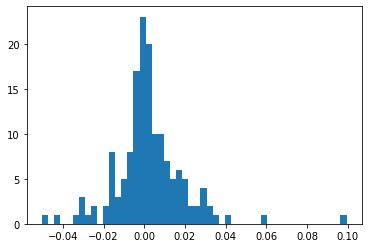

In [49]:
import matplotlib.pyplot as plt
a = [i for i in list(case1.results.strategy) if not i == 0.0 ]
plt.hist(a, bins=50)

In [12]:
_delete_log_result()
date_start = datetime(2017,10,1)
date_end = datetime(2022,3,31)
data_raw1 = define_data(date_start,date_end,'KRW-BTC', time_start=9)
data_raw_temp = define_data(date_start,date_end,'KRW-BTC', time_start=11)
data_raw2 = data_raw1.copy()
data_raw2.close = data_raw_temp.close.copy()
case1 = Backtest(data_raw1,Strategy_Volatility, strategy_list=['base'])
case1.cal_strategy()
case1.cal_result()
case1.analyze_result_ind()
case1.analyze_result_cont()
case1.case_name = 'base'
case1.add_log_result()
case2 = Backtest(data_raw2,Strategy_Volatility, strategy_list=['base'])
case2.cal_strategy()
case2.cal_result()
case2.analyze_result_ind()
case2.analyze_result_cont()
case2.case_name = 'close10'
case2.add_log_result()
dict_log_result

log 삭제 완료


{'case 1': ['base',
  563,
  300,
  0.53,
  1.44,
  0.52,
  2.47,
  -1.71,
  1259.21,
  49.29,
  -28.58,
  13.06,
  3.77],
 'case 2': ['close10',
  563,
  299,
  0.53,
  1.52,
  0.65,
  2.9,
  -1.9,
  2439.42,
  64.33,
  -33.24,
  15.36,
  4.19]}

In [119]:
_delete_log_result()
date_start = datetime(2017,10,1)
date_end = datetime(2022,3,31)
code_coin = 'KRW-BTC'

list_strategy_detail = ['volume_filter, 10000000000', 'volume_trend_filter, sma, 5', 'price_trend_filter, sma, 5', 'price_noise_filter, 0.4']
    
n1=[]
n2=[]
for start_time in range(24):
    data_raw_temp = define_data(date_start,date_end,code_coin, time_start=start_time)
    for strategy_detail in list_strategy_detail:
        case_temp = Backtest(data_raw_temp,Strategy_Volatility,['base', strategy_detail])
        case_temp.case_name = [start_time, strategy_detail]
        n1.append(start_time)
        n2.append(strategy_detail)
        case_temp.cal_strategy()
        case_temp.cal_result()
        case_temp.analyze_result_ind()
        case_temp.analyze_result_cont()
        case_temp.add_log_result()
_return_log_result()

log 삭제 완료
--------------------
거래횟수 (상승) : 31530 ( 16553 )
승률 : 0.52
손익비 : 1.48
거래 당 기대수익률 (상승/하락) : 0.51 ( 2.51 / -1.69 )


In [11]:
name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
df1 = pd.DataFrame(dict_log_result,index=name_list).T
df1
# df1['time'] = n1
# df1['strategy'] = n2
# df1.to_csv('test1.csv')

,name,number_of_trading,number_of_trading_positive,hit_ratio,gain_loss_ratio,expactacy_per_trade,average_gain,average_loss,total_profit,cagr,mdd,std,sharpe_ratio
case 1,base,563,300,0.53,1.44,0.52,2.47,-1.71,1259.21,49.29,-28.58,13.06,3.77
case 2,close10,563,301,0.53,1.51,0.62,2.76,-1.83,2234.54,62.22,-27.68,14.33,4.34
case 3,base,563,300,0.53,1.44,0.52,2.47,-1.71,1259.21,49.29,-28.58,13.06,3.77
case 4,close10,563,301,0.53,1.51,0.62,2.76,-1.83,2234.54,62.22,-27.68,14.33,4.34
case 5,base,563,300,0.53,1.44,0.52,2.47,-1.71,1259.21,49.29,-28.58,13.06,3.77
case 6,close10,563,301,0.53,1.51,0.62,2.76,-1.83,2234.54,62.22,-27.68,14.33,4.34


In [81]:
_delete_log_result()
date_start = datetime(2017,10,1)
date_end = datetime(2022,3,31)
code_coin = 'KRW-BTC'

list_strategy_detail_volume_trend = ['None']
base_strategy = 'volume_trend_filter'
for method in ['sma', 'ema', 'wma']:
    for days in range(3,10):
        list_strategy_detail_volume_trend.append(f'{base_strategy}, {method}, {days}')

list_strategy_detail_price_trend = ['None']
base_strategy = 'price_trend_filter'
for method in ['sma', 'ema', 'wma']:
    for days in range(3,10):
        list_strategy_detail_price_trend.append(f'{base_strategy}, {method}, {days}')

list_strategy_detail_volume = ['None']
base_strategy = 'volume_filter'
for i in np.arange(8,12,0.5):
    volume = int(_power10(i))
    list_strategy_detail_volume.append(f'{base_strategy}, {volume}')

n1=[]
n2=[]
n3=[]
n4=[]
for start_time in range(24):
    data_raw_temp = define_data(date_start,date_end,code_coin, time_start=start_time)
    for V in list_strategy_detail_volume:
        for VT in list_strategy_detail_volume_trend:
            for PT in list_strategy_detail_price_trend:
                case_temp = Backtest(data_raw_temp,Strategy_Volatility,['base', V, VT, PT])
                case_temp.case_name = [start_time, V, VT, PT]
                n1.append(start_time)
                n2.append(V)
                n3.append(VT)
                n4.append(PT)
                case_temp.cal_strategy()
                case_temp.cal_result()
                case_temp.analyze_result_ind()
                case_temp.analyze_result_cont()
                case_temp.add_log_result()
_return_log_result()

log 삭제 완료
--------------------
거래횟수 (상승) : 12164972 ( 6410166 )
승률 : 0.53
손익비 : 1.41
거래 당 기대수익률 (상승/하락) : 0.52 ( 2.72 / -1.92 )


In [82]:
name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
df1 = pd.DataFrame(dict_log_result,index=name_list).T
df1['time'] = n1
df1['volume'] = n2
df1['volume_trend'] = n3
df1['price_trend'] = n4
df1.to_csv('test1.csv')

In [65]:
data_raw_hourly['hour'] = data_raw_hourly.date.apply(lambda x : x.hour)
data_raw_hourly['return'] = ((data_raw_hourly['close']-data_raw_hourly['open'])/data_raw_hourly['open'])
data_raw_hourly_temp = data_raw_hourly[['hour','return']]
data_raw_hourly_temp.dropna(inplace=True)
data_raw_hourly_temp.groupby(['hour']).mean()

,return
hour,
0,0.000441
1,0.000133
2,-0.000229
3,0.000150
4,0.000736
5,0.000473
6,0.000829
7,0.000587
8,0.000113


In [ ]:
_delete_log_result()
date_start = datetime(2017,10,1)
date_end = datetime(2022,3,31)
tickers = pyupbit.get_tickers(fiat="KRW")
list_eroor_coin = []
for code_coin in tqdm(tickers):
    try:
        data_raw_temp = define_data(date_start,date_end,code_coin)
        case1 = Backtest(data_raw_temp,Strategy_Volatility)
        case1.case_name = code_coin
        case1.calculate_strategy()
        case1.calculate_result()
        # case1.plot_results()
        case1.summary_results()
        case1.simple_analyzer()
        case1.add_log_result()
    except:
        list_eroor_coin.append(code_coin)
print(list_eroor_coin)
_return_log_result()

In [ ]:
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base','volume_filter','volume_trend_filter','price_trend_filter'])
case1 = Backtest(data_raw_hourly,Strategy_Volatility, strategy_list=[list_strategy_detail[0]])
case1.cal_strategy()
# case1.test_result
case1.cal_result()
# case1.analyze_result_per()
# case1.plot_analysis_per()
# case1.analyze_result_ind()
case1.analyze_result_cont()
# case1.plot_results()
# case1.case_name


In [ ]:
1.65**6.5

In [59]:
list_strategy_detail[0]

'volume_trend_filter, sma, 3'

In [58]:
# case1 = Backtest(data_raw_hourly,Strategy_Volatility, strategy_list=['stoploss'])
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base','volume_filter, 100000000000'])
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base','volume_trend_filter, sma, 5'])
# case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=['base','price_trend_filter, sma, 5'])
case1 = Backtest(data_raw,Strategy_Volatility, strategy_list=[list_strategy_detail[0]])
case1.cal_strategy()
# case1.test_result
case1.cal_result()
# case1.plot_results()
# case1.analyze_result_per()
# case1.plot_analysis_per()
# case1.analyze_result_ind()
case1.analyze_result_cont()

AttributeError: 'DataFrame' object has no attribute 'buy_entry'

In [ ]:
int(float('1000'))

In [ ]:
volume_filter, target_volume : 10**11